# Hyperparameter Tuning for Time Series Forecasting

In previous tutorials, we learned how to forecast univariate time series, apply transformations, and build pipelines. In this tutorial, we explore how to systematically find the best hyperparameters for our forecasters using sktime's tuning capabilities.

Hyperparameter tuning is the process of searching for the optimal configuration of a model. Instead of manually trying different parameter combinations, we can automate this search using cross-validation to find settings that generalize well.

**Duration:** ~15 minutes

## Learning objectives

By the end of this tutorial, you will be able to:
- Understand what hyperparameters are and why tuning matters
- Use `ForecastingGridSearchCV` for systematic parameter search
- Tune both simple models and complex pipelines

## 1. Loading the Dataset

We will use the classic airline passengers dataset throughout this tutorial.

In [12]:
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import pandas as pd

from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

In [13]:
y = load_airline()
y

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64

We split the data into training and test sets. The test set (last 12 months) will be held out for final evaluation.

In [14]:
y_train = y.iloc[:-12]
y_test = y.iloc[-12:]

print(f"Training: {len(y_train)} observations")
print(f"Test: {len(y_test)} observations")

Training: 132 observations
Test: 12 observations


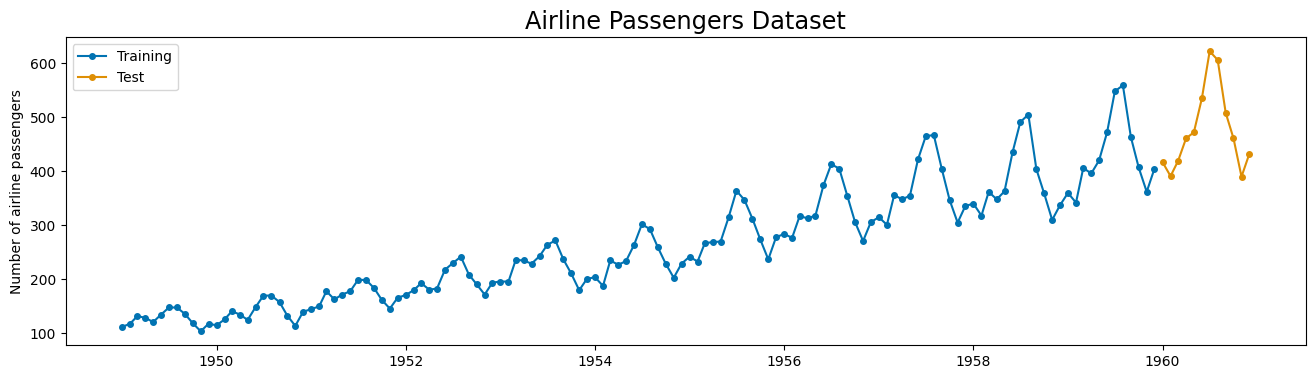

In [15]:
plot_series(
    y_train, y_test, labels=["Training", "Test"], title="Airline Passengers Dataset"
)
plt.show()

## 2. Understanding Hyperparameters

Hyperparameters are configuration settings that control how a model learns. Unlike model parameters (which are learned from data), hyperparameters must be set before training.

Let's examine the hyperparameters of an Exponential Smoothing model:

In [16]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

forecaster = ExponentialSmoothing(sp=12)
forecaster

ExponentialSmoothing(sp=12)

We can use `get_params()` to see all configurable hyperparameters:

In [17]:
forecaster.get_params()

{'damped_trend': False,
 'damping_trend': None,
 'initial_level': None,
 'initial_seasonal': None,
 'initial_trend': None,
 'initialization_method': 'estimated',
 'method': None,
 'minimize_kwargs': None,
 'optimized': True,
 'random_state': None,
 'remove_bias': False,
 'seasonal': None,
 'smoothing_level': None,
 'smoothing_seasonal': None,
 'smoothing_trend': None,
 'sp': 12,
 'start_params': None,
 'trend': None,
 'use_boxcox': None,
 'use_brute': True}

Key hyperparameters for Exponential Smoothing include:
- `trend`: Type of trend component (`None`, `"add"`, or `"mul"`)
- `seasonal`: Type of seasonal component (`None`, `"add"`, or `"mul"`)
- `damped_trend`: Whether to dampen the trend
- `sp`: Seasonal period (we set this to 12 for monthly data)

Manually testing all combinations would be tedious. Let's automate this with grid search.

## 3. Grid Search for Hyperparameter Tuning

Grid search exhaustively evaluates all combinations of specified hyperparameters using cross-validation. In this tutorial, we use `ForecastingGridSearchCV`, but we also have other options:

* ForecastingOptCV: uses [Hyperactive](https://github.com/hyperactive-project/Hyperactive) as optimization backend.
* ForecastingOptunaSearchCV: uses [Optuna](https://optuna.org/) as optimization backend.
* ForecastingRandomizedSearchCV: randomly samples hyperparameter combinations.

### 3.1 Define the parameter grid

First, we specify which parameters to tune and their candidate values:

In [18]:
param_grid = {
    "trend": [None, "add", "mul"],
    "seasonal": [None, "add", "mul"],
    "damped_trend": [True, False],
}
param_grid

{'trend': [None, 'add', 'mul'],
 'seasonal': [None, 'add', 'mul'],
 'damped_trend': [True, False]}

This grid has 3 × 3 × 2 = 18 combinations to evaluate.

### 3.2 Set up cross-validation

We need a cross-validation strategy that respects the temporal order of our data. `ExpandingWindowSplitter` uses an expanding training window:

In [19]:
from sktime.split import ExpandingWindowSplitter

cv = ExpandingWindowSplitter(
    initial_window=60,  # Start with 60 observations
    step_length=12,  # Move forward 12 observations each fold
    fh=[1, 3, 6, 12],  # Forecast horizons to evaluate
)
cv

ExpandingWindowSplitter(fh=[1, 3, 6, 12], initial_window=60, step_length=12)

In [20]:
print(f"Number of CV folds: {cv.get_n_splits(y_train)}")

Number of CV folds: 6


### 3.3 Create and fit the grid search tuner

Now we combine everything into a `ForecastingGridSearchCV` object:

In [54]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

tuner = ForecastingGridSearchCV(
    forecaster=ExponentialSmoothing(sp=12),
    cv=cv,
    param_grid=param_grid,
    scoring=MeanAbsolutePercentageError(),  # use your preferred metric
    n_jobs=1,  # Set to -1 for parallel processing
    backend=None,  # Set to "loky" or "threading" for parallel processing!
    refit=True,
)
tuner

ForecastingGridSearchCV(backend=None,
                        cv=ExpandingWindowSplitter(fh=[1, 3, 6, 12],
                                                   initial_window=60,
                                                   step_length=12),
                        forecaster=ExponentialSmoothing(sp=12), n_jobs=1,
                        param_grid={'damped_trend': [True, False],
                                    'seasonal': [None, 'add', 'mul'],
                                    'trend': [None, 'add', 'mul']},
                        scoring=MeanAbsolutePercentageError())

Fit the tuner on the training data. This will evaluate all 18 parameter combinations across all CV folds:

In [55]:
tuner.fit(y_train)

ForecastingGridSearchCV(backend=None,
                        cv=ExpandingWindowSplitter(fh=[1, 3, 6, 12],
                                                   initial_window=60,
                                                   step_length=12),
                        forecaster=ExponentialSmoothing(sp=12), n_jobs=1,
                        param_grid={'damped_trend': [True, False],
                                    'seasonal': [None, 'add', 'mul'],
                                    'trend': [None, 'add', 'mul']},
                        scoring=MeanAbsolutePercentageError())

### 3.4 Inspect the results

The best parameters and score are available as attributes:

In [56]:
tuner.best_params_

{'damped_trend': False, 'seasonal': 'mul', 'trend': 'add'}

In [57]:
print(f"Best MAPE score: {tuner.best_score_:.4f}")

Best MAPE score: 0.0388


The `best_forecaster_` attribute contains the fitted model with optimal parameters:

In [58]:
tuner.best_forecaster_

ExponentialSmoothing(seasonal='mul', sp=12, trend='add')

## 4. Analyzing Tuning Results

The `cv_results_` attribute contains detailed information about all evaluated combinations.

In [59]:
results_df = pd.DataFrame(tuner.cv_results_)
results_df.head()

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,NaN,NaN,NaN,"{'damped_trend': True, 'seasonal': None, 'tren...",NaN
1,0.117946,0.009793,0.003089,"{'damped_trend': True, 'seasonal': None, 'tren...",12.0
2,0.121930,0.014558,0.002975,"{'damped_trend': True, 'seasonal': None, 'tren...",13.0
3,NaN,NaN,NaN,"{'damped_trend': True, 'seasonal': 'add', 'tre...",NaN
4,0.057886,0.035914,0.003123,"{'damped_trend': True, 'seasonal': 'add', 'tre...",8.0


Let's see the top 5 parameter combinations by performance:

In [60]:
top_results = results_df.nsmallest(5, "mean_test_MeanAbsolutePercentageError")
top_results

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
16,0.038830,0.042905,0.003094,"{'damped_trend': False, 'seasonal': 'mul', 'tr...",1.0
8,0.041554,0.088594,0.004061,"{'damped_trend': True, 'seasonal': 'mul', 'tre...",2.0
7,0.043225,0.047129,0.003133,"{'damped_trend': True, 'seasonal': 'mul', 'tre...",3.0
17,0.045815,0.081094,0.003272,"{'damped_trend': False, 'seasonal': 'mul', 'tr...",4.0
5,0.049227,0.073724,0.003221,"{'damped_trend': True, 'seasonal': 'add', 'tre...",5.0


### 4.1 Visualizing parameter effects

We can analyze how each parameter affects model performance:

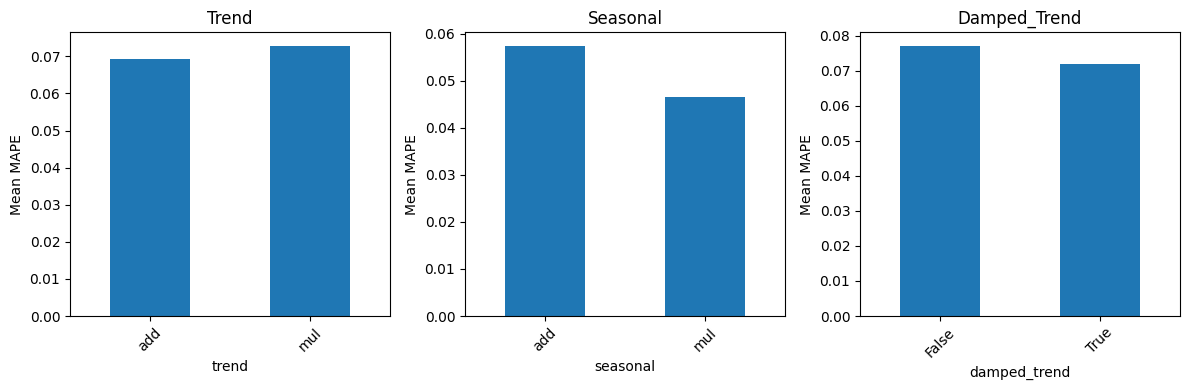

In [61]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

expanded = pd.json_normalize(results_df.params)
expanded = results_df.join(expanded)
# Effect of each parameter
for ax, param in zip(axes, ["trend", "seasonal", "damped_trend"]):
    scores = expanded.groupby(param)["mean_test_MeanAbsolutePercentageError"].mean()
    scores.plot(kind="bar", ax=ax, title=param.replace("param_", "").title())
    ax.set_ylabel("Mean MAPE")
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

## 5. Tuning Pipeline Compositions

When working with pipelines (see the pipelines tutorial), we can tune parameters across all components. The parameter names follow a nested structure.

In [62]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.transformations.series.detrend import Detrender

### 5.1 Create a forecasting pipeline

Let's build a pipeline with transformations followed by a forecaster:

In [63]:
pipeline = TransformedTargetForecaster(
    [
        ("boxcox", BoxCoxTransformer()),
        ("detrend", Detrender()),
        ("forecaster", ExponentialSmoothing(sp=12)),
    ]
)
pipeline

TransformedTargetForecaster(steps=[('boxcox', BoxCoxTransformer()),
                                   ('detrend', Detrender()),
                                   ('forecaster', ExponentialSmoothing(sp=12))])

### 5.2 Discover pipeline parameters

Use `get_params()` to see the nested parameter structure:

In [64]:
pipeline.get_params()

{'steps': [('boxcox', BoxCoxTransformer()),
  ('detrend', Detrender()),
  ('forecaster', ExponentialSmoothing(sp=12))],
 'boxcox': BoxCoxTransformer(),
 'detrend': Detrender(),
 'forecaster': ExponentialSmoothing(sp=12),
 'boxcox__bounds': None,
 'boxcox__enforce_positive': True,
 'boxcox__lambda_fixed': 0.0,
 'boxcox__method': 'mle',
 'boxcox__sp': None,
 'detrend__forecaster': None,
 'detrend__model': 'additive',
 'forecaster__damped_trend': False,
 'forecaster__damping_trend': None,
 'forecaster__initial_level': None,
 'forecaster__initial_seasonal': None,
 'forecaster__initial_trend': None,
 'forecaster__initialization_method': 'estimated',
 'forecaster__method': None,
 'forecaster__minimize_kwargs': None,
 'forecaster__optimized': True,
 'forecaster__random_state': None,
 'forecaster__remove_bias': False,
 'forecaster__seasonal': None,
 'forecaster__smoothing_level': None,
 'forecaster__smoothing_seasonal': None,
 'forecaster__smoothing_trend': None,
 'forecaster__sp': 12,
 'forec

**Note:** Pipeline parameters use double underscores (`__`) to access nested components. For example, `forecaster__trend` refers to the `trend` parameter of the `forecaster` step.

### 5.3 Define the pipeline parameter grid

In [65]:
pipeline_param_grid = {
    "boxcox__method": ["mle", "pearsonr"],
    "forecaster__trend": [None, "add"],
    "forecaster__seasonal": ["add", "mul"],
    "forecaster__damped_trend": [True, False],
}
pipeline_param_grid

{'boxcox__method': ['mle', 'pearsonr'],
 'forecaster__trend': [None, 'add'],
 'forecaster__seasonal': ['add', 'mul'],
 'forecaster__damped_trend': [True, False]}

### 5.4 Tune the pipeline

In [66]:
pipeline_tuner = ForecastingGridSearchCV(
    forecaster=pipeline,
    cv=cv,
    param_grid=pipeline_param_grid,
    scoring=MeanAbsolutePercentageError(),
    n_jobs=1,
    refit=True,
    backend=None,
)

pipeline_tuner.fit(y_train)

ForecastingGridSearchCV(backend=None,
                        cv=ExpandingWindowSplitter(fh=[1, 3, 6, 12],
                                                   initial_window=60,
                                                   step_length=12),
                        forecaster=TransformedTargetForecaster(steps=[('boxcox',
                                                                       BoxCoxTransformer()),
                                                                      ('detrend',
                                                                       Detrender()),
                                                                      ('forecaster',
                                                                       ExponentialSmoothing(sp=12))]),
                        n_jobs=1,
                        param_grid={'boxcox__method': ['mle', 'pearsonr'],
                                    'forecaster__damped_trend': [True, False],
                                    'forecaster__seasonal': ['add', 'mul'],
                                    'forecaster__trend': [None, 'add']},
                        scoring=MeanAbsolutePercentageError())

In [67]:
pipeline_tuner.best_params_

{'boxcox__method': 'pearsonr',
 'forecaster__damped_trend': False,
 'forecaster__seasonal': 'add',
 'forecaster__trend': None}

In [68]:
print(f"Best pipeline MAPE: {pipeline_tuner.best_score_:.4f}")

Best pipeline MAPE: 0.0395


## 7. Nested Tuning for Unbiased Evaluation

To avoid optimistic estimates, we can nest hyperparameter tuning inside an outer evaluation loop. The inner loop tunes hyperparameters; the outer loop measures generalization.

In [69]:
# Outer CV for evaluation
over_cv = ExpandingWindowSplitter(initial_window=72, step_length=6, fh=[1, 6, 12])

# Inner CV for tuning (reuse the grid defined earlier)
inner_cv = ExpandingWindowSplitter(initial_window=60, step_length=12, fh=[1, 3, 6, 12])

print(f"Outer CV folds: {over_cv.get_n_splits(y)}")
print(f"Inner CV folds: {inner_cv.get_n_splits(y_train)}")

Outer CV folds: 11
Inner CV folds: 6


Run nested CV: the tuner fits inside each outer fold using the inner CV splitter.

In [73]:
from sktime.forecasting.model_evaluation import evaluate

nested_tuner = ForecastingGridSearchCV(
    forecaster=ExponentialSmoothing(sp=12),
    cv=inner_cv,
    param_grid=param_grid,
    scoring=MeanAbsolutePercentageError(),
    n_jobs=1,
    refit=True,
    backend=None,
)

nested_cv_results = evaluate(
    forecaster=nested_tuner,
    y=y,
    cv=over_cv,
    scoring=MeanAbsolutePercentageError(),
    return_data=False,
)
nested_cv_results

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,0.059707,0.832778,0.003670,72,1954-12
1,0.047734,0.831048,0.003247,78,1955-06
2,0.059443,1.534334,0.003093,84,1955-12
3,0.026064,1.430956,0.003332,90,1956-06
4,0.026412,2.135298,0.003375,96,1956-12
5,0.055397,2.106338,0.003794,102,1957-06
6,0.110607,2.822480,0.003216,108,1957-12
7,0.043582,2.815355,0.003374,114,1958-06
8,0.040939,3.356818,0.003400,120,1958-12
9,0.041491,3.529600,0.003329,126,1959-06


In [74]:
mean_nested = nested_cv_results["test_MeanAbsolutePercentageError"].mean()
std_nested = nested_cv_results["test_MeanAbsolutePercentageError"].std()
print(f"Nested CV MAPE: {mean_nested:.4f} ± {std_nested:.4f}")

Nested CV MAPE: 0.0475 ± 0.0259


## 8. Other Tuning Strategies

Beyond grid search, sktime supports alternative optimizers. These require optional dependencies (install with the appropriate extras).


- **ForecastingOptCV** (Hyperactive backend; install `hyperactive>=5`)
Hyperactive provides more than 30 different algorithmns, and 3 different backends. See the [Hyperactive documentation](https://hyperactive.readthedocs.io/en/latest/index.html) for details.

```python
from sktime.forecasting.naive import NaiveForecaster
from sktime.split import temporal_train_test_split, ExpandingWindowSplitter
from hyperactive.integrations.sktime import ForecastingOptCV
from hyperactive.opt import GridSearchSk as GridSearch

# Define search space
param_grid = {"strategy": ["mean", "last", "drift"]}

# Create tuned forecaster
tuned_forecaster = ForecastingOptCV(
    NaiveForecaster(),
    GridSearch(param_grid),
    cv=ExpandingWindowSplitter(
        initial_window=12,
        step_length=3,
        fh=range(1, 13),
    ),
)
```


- **ForecastingRandomizedSearchCV** (random sampling; needs `scipy` for distributions)
```python
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV
from scipy.stats import uniform

rand_tuner = ForecastingRandomizedSearchCV(
    forecaster=ExponentialSmoothing(sp=12),
    cv=cv,
    param_distributions={
        "trend": [None, "add", "mul"],
        "alpha": uniform(0.01, 0.5),  # example continuous parameter
    },
    n_iter=10,
    scoring=MeanAbsolutePercentageError(),
    random_state=42,
)
```

- **ForecastingOptunaSearchCV** (Optuna backend; install `optuna`)
```python
from sktime.forecasting.model_selection import ForecastingOptunaSearchCV

optuna_tuner = ForecastingOptunaSearchCV(
    forecaster=ExponentialSmoothing(sp=12),
    cv=cv,
    param_distributions={"trend": [None, "add", "mul"]},
    n_trials=20,
    scoring=MeanAbsolutePercentageError(),
    random_state=42,
)
```

## 9. Best Practices

Key guidelines for effective hyperparameter tuning:

### Separate validation from final testing

- Use different CV splitters for tuning and evaluation
- Never tune on your final test set
- Consider nested CV for unbiased performance estimates

### Design your parameter space thoughtfully

- Start with wide ranges, then narrow down
- Use domain knowledge to guide parameter choices

### Balance computational cost

- Use `n_jobs=-1` for parallel processing
- Start with a coarse grid, then refine
- Consider randomized search for large spaces

**Tip:** Check if tuning actually helps by comparing against a well-chosen baseline. Small improvements may not justify the computational cost.

## Key Takeaways

* **Hyperparameters** are model settings that must be chosen before training
* Use `get_params()` to discover tunable parameters for any estimator
* `ForecastingGridSearchCV` systematically searches parameter combinations using CV
* Pipeline parameters use double underscores (`__`) for nested access
* Always use a **separate validation strategy** for tuning vs. final evaluation
* Consider the **computational cost** vs. performance improvement trade-off
* Sktime supports multiple tuning strategies, including grid search, random search, and optimization-based search